In [1]:
###Importing the modules###

import numpy as np
import xarray as xr
import math as mt
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats
from collections import Counter
import cftime

print("Done importing modules")

Done importing modules


In [2]:
###Import the datasets for all CFs###

AllCF_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_723.nc')
AllCF_df

CF_df_LP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_LP145.nc')
#CF_df_LP

CF_df_HP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_HP145.nc')
#CF_df_HP

AllCF_df = AllCF_df.copy()

In [3]:
##Now work on munging the MJO data##

#Read in the csv#
MJO_df = pd.read_csv('Other_Data/rmm.74toRealtime.txt', sep='\s+', engine='python')
#MJO_df.head(20)

#Drop any extra columns after amplitude#
MJO_df = MJO_df.drop(columns=['Missing', 'Value=', '1.E36', '1.E36', 'or', '999'])
#MJO_df

#Remove extra years such as 2023, 2024#
MJO_df.drop(MJO_df[MJO_df['year,'] > 2022].index, inplace=True)
MJO_df

,"year,","month,","day,","RMM1,","RMM2,","phase,",amplitude.
0,1974,6,1,1.634470,1.203040,5,2.029480
1,1974,6,2,1.602890,1.015120,5,1.897290
2,1974,6,3,1.516250,1.085510,5,1.864760
3,1974,6,4,1.509810,1.035730,5,1.830920
4,1974,6,5,1.559060,1.305180,5,2.033260
...,...,...,...,...,...,...,...
17741,2022,12,27,1.297065,0.946596,5,1.605746
17742,2022,12,28,1.110525,1.064370,5,1.538229
17743,2022,12,29,0.700675,1.421565,6,1.584863
17744,2022,12,30,0.308495,1.622294,6,1.651366


In [4]:
###Convert the columns to datetime64 object in MJO_df for apples to apples comparison###

#Clean up the data by removing the periods, commas, and whitespace#
MJO_df.columns = [col.strip() for col in MJO_df.columns]
MJO_df.columns = MJO_df.columns.str.replace(',', '')
MJO_df.columns = MJO_df.columns.str.replace('.', '')

#Convert 3 date columns into one#
MJO_df['date'] = pd.to_datetime(MJO_df[['year', 'month', 'day']])

#Reorder the columns#
desired_order = ['date', 'year', 'month', 'day', 'amplitude', 'phase', 'RMM1', 'RMM2']
MJO_df = MJO_df[desired_order]

MJO_df

,date,year,month,day,amplitude,phase,RMM1,RMM2
0,1974-06-01,1974,6,1,2.029480,5,1.634470,1.203040
1,1974-06-02,1974,6,2,1.897290,5,1.602890,1.015120
2,1974-06-03,1974,6,3,1.864760,5,1.516250,1.085510
3,1974-06-04,1974,6,4,1.830920,5,1.509810,1.035730
4,1974-06-05,1974,6,5,2.033260,5,1.559060,1.305180
...,...,...,...,...,...,...,...,...
17741,2022-12-27,2022,12,27,1.605746,5,1.297065,0.946596
17742,2022-12-28,2022,12,28,1.538229,5,1.110525,1.064370
17743,2022-12-29,2022,12,29,1.584863,6,0.700675,1.421565
17744,2022-12-30,2022,12,30,1.651366,6,0.308495,1.622294


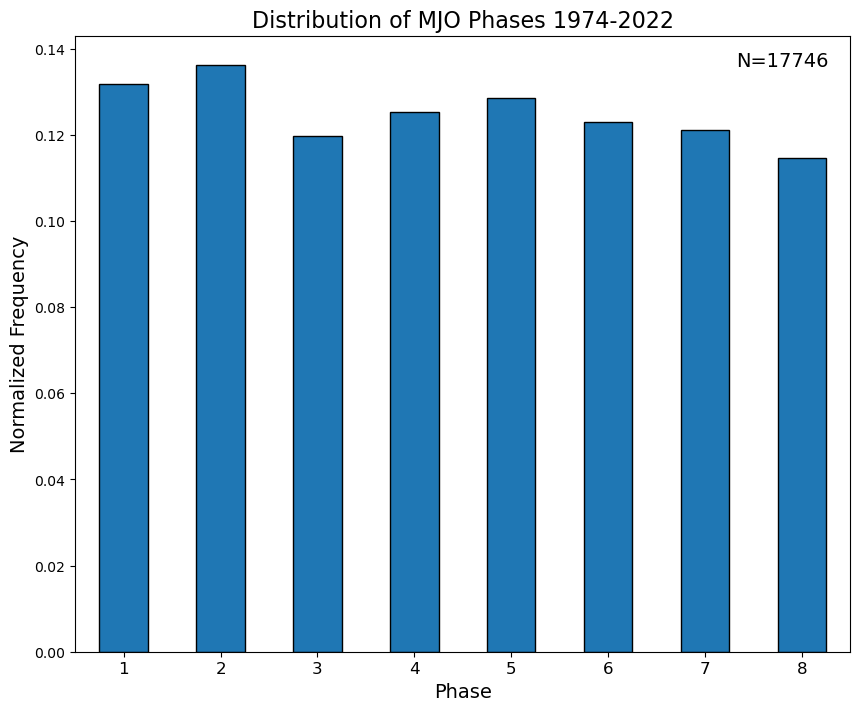

In [5]:
###Normalize and plot the phases for the MJO###

#Delete missing data#
MJO_df['phase'] = MJO_df['phase'].replace(999, np.nan)

columns_to_mask = ['RMM1', 'RMM2', 'amplitude']  #remove missing data for these 3 columns

for col in columns_to_mask:
    
    MJO_df[col] = MJO_df[col].mask(MJO_df[col] > 1e5, np.nan)

#Sort by phase frequency and normalize#
frequency = MJO_df['phase'].value_counts(normalize=True, dropna=True)
frequency = frequency.sort_index()

#Plotting#
plt.figure(figsize=(10, 8)) 
ax = frequency.plot(kind='bar', edgecolor='black')

ax.set_xlabel('Phase', fontsize=14)
ax.set_ylabel('Normalized Frequency', fontsize=14)
ax.set_title('Distribution of MJO Phases 1974-2022', fontsize=16)
ax.set_xticklabels(frequency.index.astype(int), fontsize=12, rotation=0)
ax.text(x=max(plt.xlim())*0.97, y=max(plt.ylim())*0.95, s='N=17746', horizontalalignment='right', fontsize=14)

plt.show()


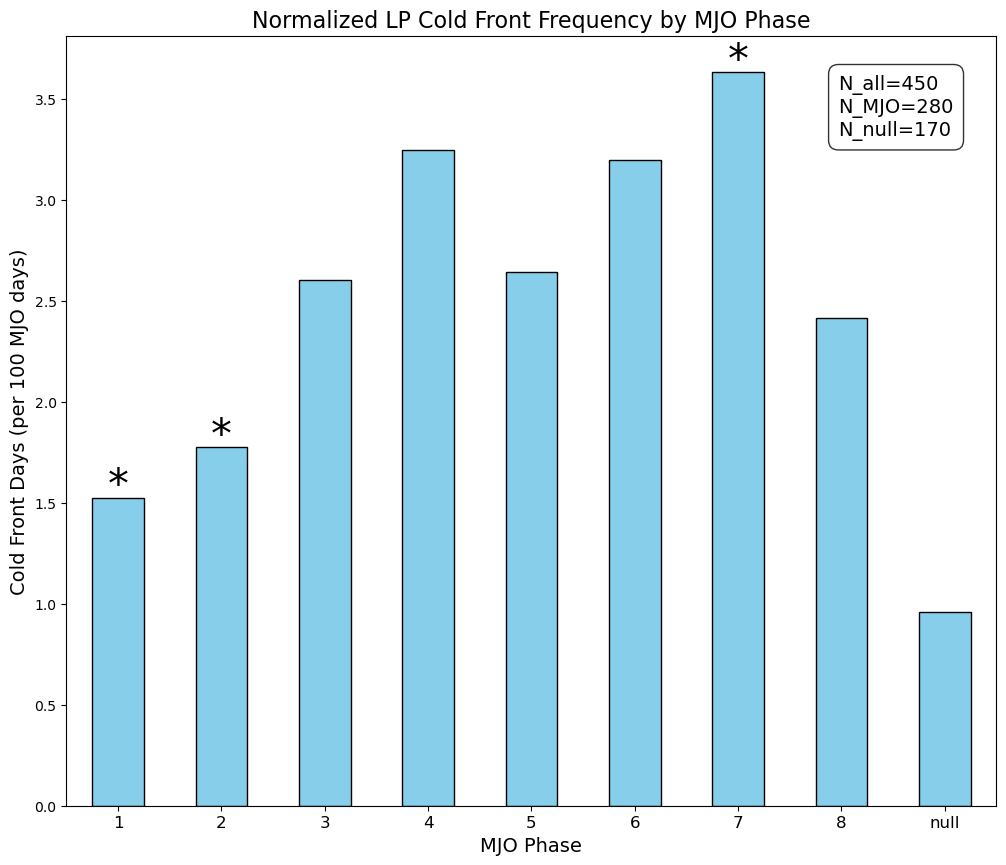

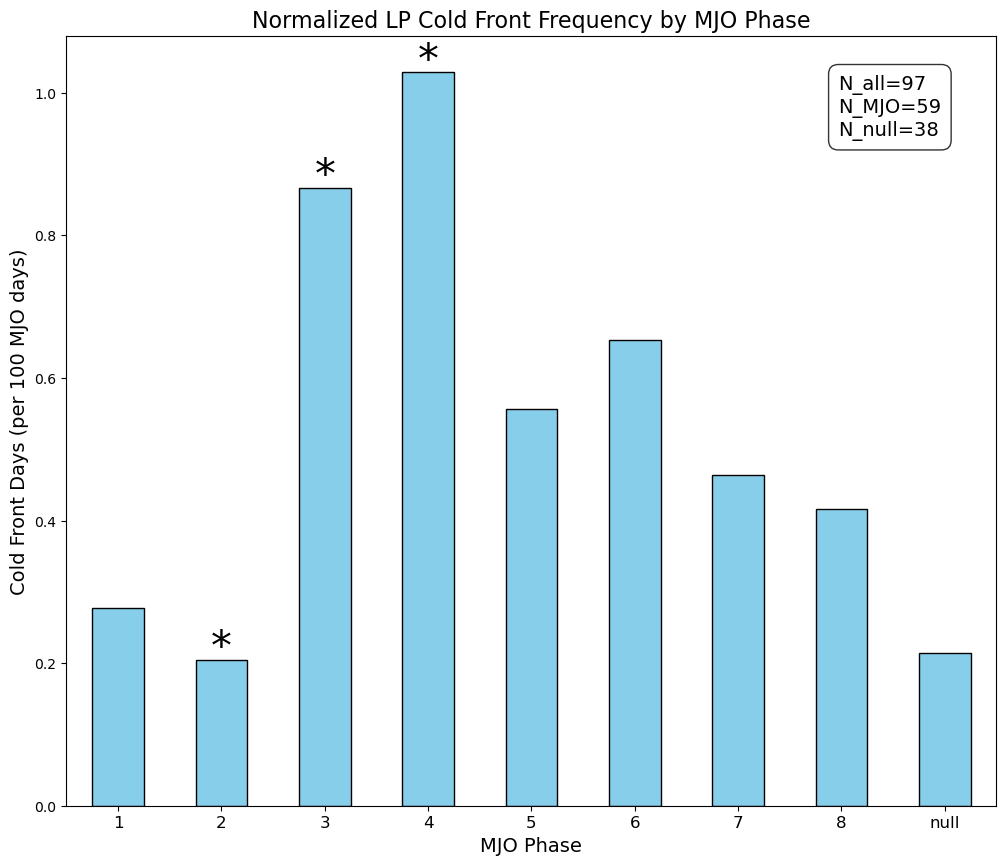

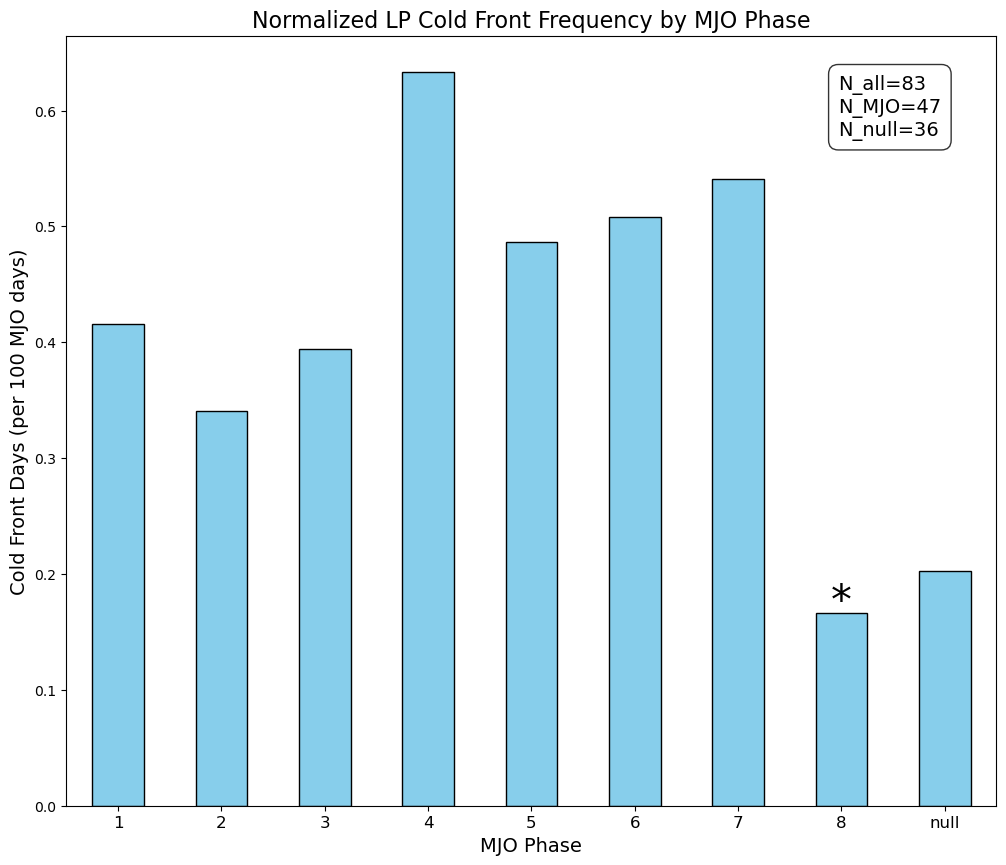

In [6]:
###Turn the MJO plot into a function###

def MJO_norm(MJO_df, CF_df, astphases=[]):
    
    #Make thresholds
    amplitude_threshold = 1
    x = 100  #Normalize to this num of days

    #Sel days when MJO was active (amp>=1)#
    MJO_active = MJO_df[MJO_df['amplitude'] >= amplitude_threshold]
    phase_days = MJO_active['phase'].value_counts().sort_index()

    #Extract cold front days that match the MJO phases#
    CF_dates = pd.to_datetime(CF_df['time'].values)
    mask_CF = MJO_active['date'].isin(CF_dates)
    MJO_CFdates = MJO_active[mask_CF]

    cold_front_counts = MJO_CFdates['phase'].value_counts().sort_index()

    #Norm by number of days in each phase and proportionalize#
    norm_cold_fronts = cold_front_counts / phase_days
    prop_cold_fronts = norm_cold_fronts * x

    ##Make a 9th bin for null phase fronts##

    #Find cold fronts that occur on days when MJO is not active (amp<1)#
    null_fronts = MJO_df['date'].isin(CF_dates) & (MJO_df['amplitude'] <= amplitude_threshold)
    null_front_count = null_fronts.sum()

    #Add a 9th bin called "null"#
    prop_cold_fronts.loc['null'] = null_front_count / len(MJO_df) * x
    
    #Plotting#
    plt.figure(figsize=(12, 10))
    ax = prop_cold_fronts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=1)

    ax.set_xlabel('MJO Phase', fontsize=14)
    ax.set_ylabel(f'Cold Front Days (per {x} MJO days)', fontsize=14)
    ax.set_title('Normalized LP Cold Front Frequency by MJO Phase', fontsize=16)
    ax.set_xticklabels(list(range(1, 9)) + ['null'], fontsize=12, rotation=0)

    total_cold_fronts = len(MJO_CFdates) + null_front_count  # Sum of cold fronts for all phases + null

    #Add sample size text box and draw a box around it#
    total_cold_fronts = len(MJO_CFdates) + null_front_count
    box_text = f'N_all={total_cold_fronts}\nN_MJO={len(MJO_CFdates)}\nN_null={null_front_count}'

    props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white', alpha=0.8)
    ax.text(x=max(ax.get_xlim())*0.82, y=max(ax.get_ylim())*0.95, s=box_text,
            fontsize=14, verticalalignment='top', bbox=props)

    #Add large asterisks on top of phases 1, 2, and 7 bars#
    #astphases = [2,3,4]

    for phase in astphases:

        idx = phase - 1   #Adjust phase to match index (0-based)
        bar_height = prop_cold_fronts.iloc[idx]
        ax.text(x=idx, y=bar_height, s='*', fontsize=30, color='black', ha='center')
        
    return prop_cold_fronts


All_CF_MJO = MJO_norm(MJO_df, AllCF_df, [1,2,7]) 
LP_CF_MJO = MJO_norm(MJO_df, CF_df_LP, [2,3,4]) 
HP_CF_MJO = MJO_norm(MJO_df, CF_df_HP, [8]) 

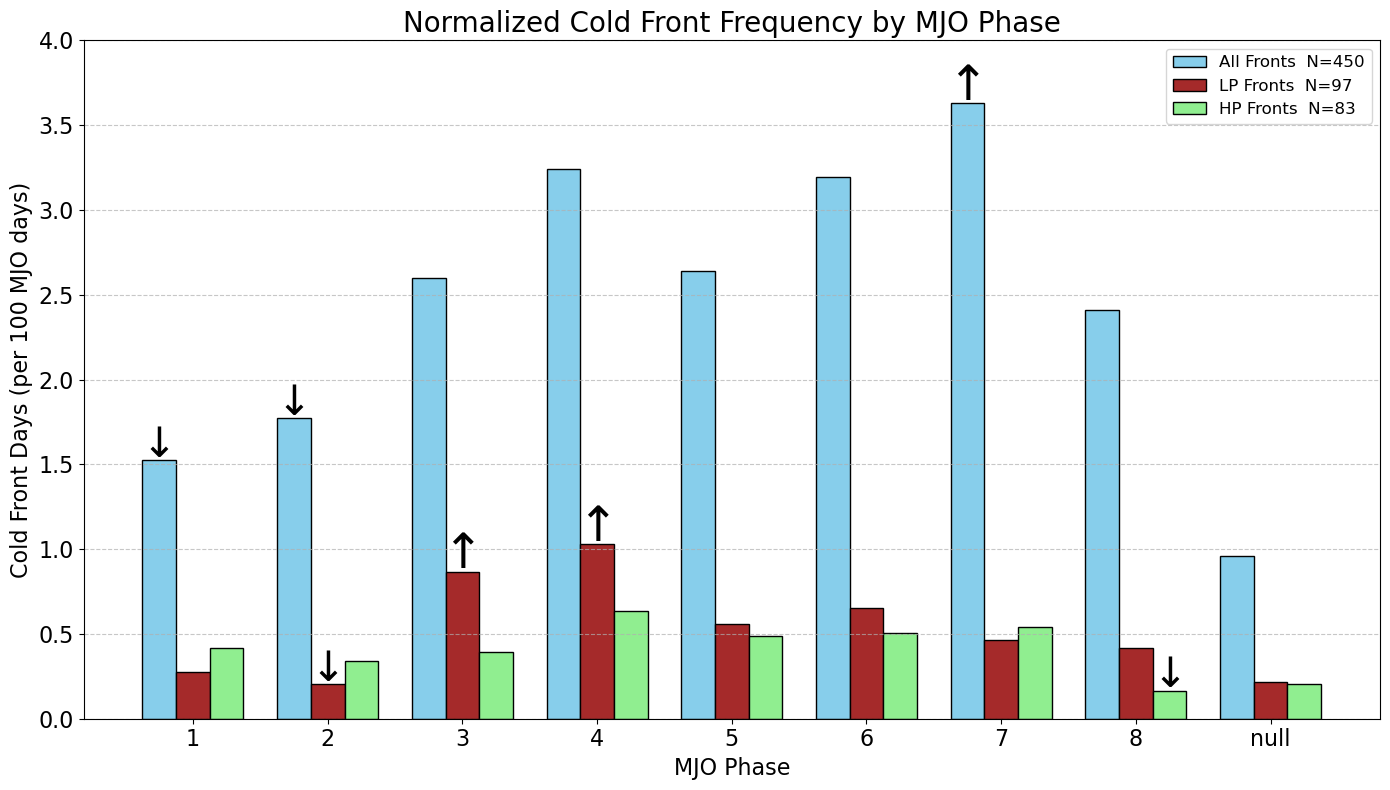

In [19]:
###Now that we have the data for all 3 groups, plot the 3-bar plot###

#Copy the data from above#
prop_cold_fronts_all = All_CF_MJO.copy()
prop_cold_fronts_lp = LP_CF_MJO.copy()
prop_cold_fronts_hp = HP_CF_MJO.copy()

#Number of bars per group (8 MJO phases + 1 null)#
num_groups = len(prop_cold_fronts_all)

#Positions of bars on x-axis#
bar_width = 0.25

r1 = np.arange(num_groups)  
r2 = [x + bar_width for x in r1]  
r3 = [x + bar_width for x in r2]  

#Plotting#
plt.figure(figsize=(14, 8))

plt.bar(r1, prop_cold_fronts_all, color='skyblue', width=bar_width, edgecolor='black', label='All Fronts  N=450')
plt.bar(r2, prop_cold_fronts_lp, color='brown', width=bar_width, edgecolor='black', label='LP Fronts  N=97')
plt.bar(r3, prop_cold_fronts_hp, color='lightgreen', width=bar_width, edgecolor='black', label='HP Fronts  N=83')

#Add the signficance asteriks#
astricks_r1 = [1,2]
for phase1 in astricks_r1:

    idx1 = phase1 - 1 
    bar_height1 = prop_cold_fronts_all.iloc[idx1]
    plt.text(x=idx1, y=bar_height1+0.02, s='↓', fontsize=30, color='black', ha='center')
    
triange_r1 = [7]
for phase1 in triange_r1:

    idx1 = phase1 - 1 
    bar_height1 = prop_cold_fronts_all.iloc[idx1]
    plt.text(x=idx1, y=bar_height1+0.02, s='↑', fontsize=35, color='black', ha='center')
    

astricks_r2 = [2]
for phase2 in astricks_r2:

    idx2 = phase2 - 1   
    bar_height2 = prop_cold_fronts_lp.iloc[idx2]
    plt.text(x=idx2+0.25, y=bar_height2+0.02, s='↓', fontsize=30, color='black', ha='center')
    
triange_r2 = [3,4]
for phase2 in triange_r2:

    idx2 = phase2 - 1 
    bar_height2 = prop_cold_fronts_lp.iloc[idx2]
    plt.text(x=idx2+0.25, y=bar_height2+0.02, s='↑', fontsize=35, color='black', ha='center')
    
triangle_r3 = [8]
for phase3 in triangle_r3:

    idx3 = phase3 - 1  
    bar_height3 = prop_cold_fronts_hp.iloc[idx3]
    plt.text(x=idx3+0.5, y=bar_height3+0.02, s='↓', fontsize=30, color='black', ha='center')

plt.xlabel('MJO Phase', fontsize=16)
plt.ylabel(f'Cold Front Days (per 100 MJO days)', fontsize=16)
plt.ylim([0,4])
plt.title('Normalized Cold Front Frequency by MJO Phase', fontsize=20)
plt.xticks([r + bar_width for r in range(num_groups)], list(range(1, 9)) + ['null'], rotation=0, fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#plt.savefig("MJO_Norm_REV.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

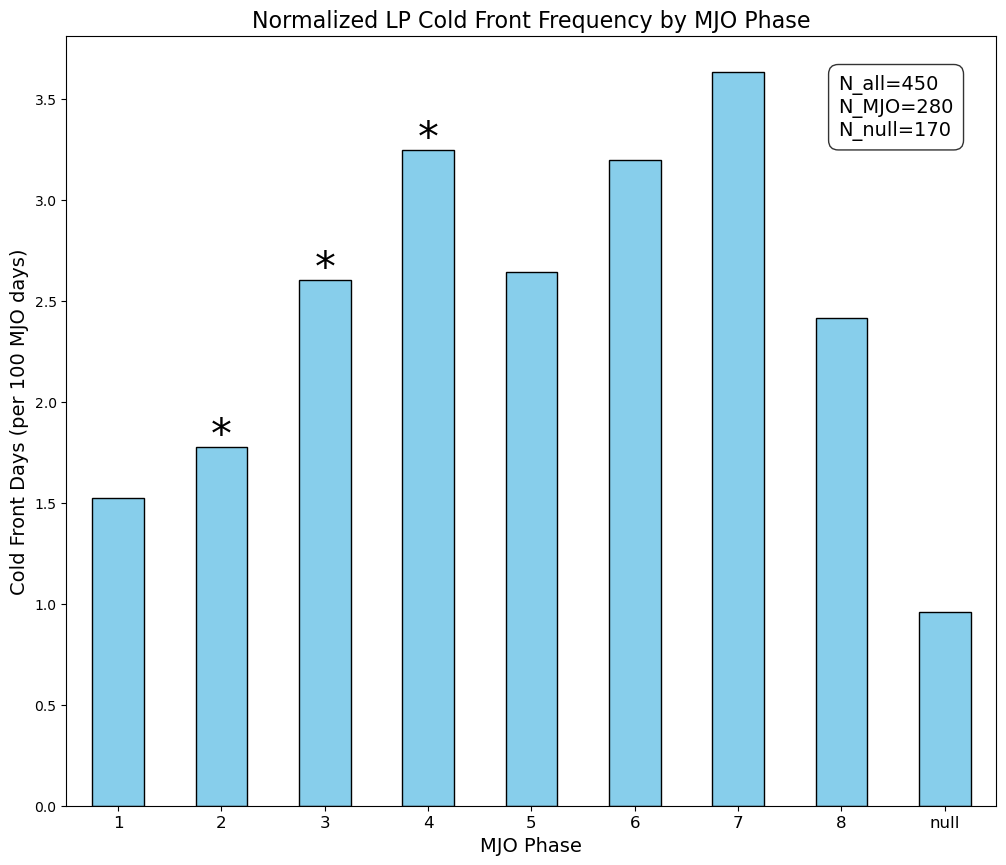

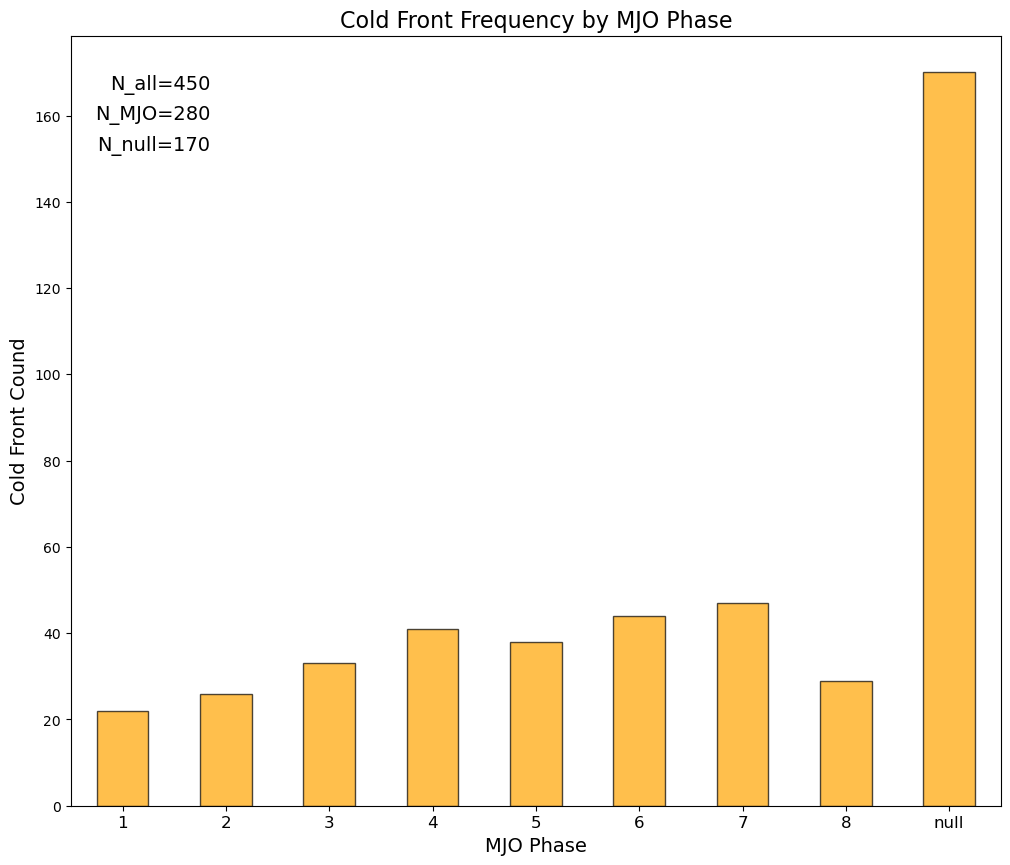

In [8]:
###We want to normalize the number of CF in each phase and make a "null" catgeory###

#Make thresholds
amplitude_threshold = 1
x = 100  #Normalize to this num of days

#Sel days when MJO was active (amp>=1)#
MJO_active = MJO_df[MJO_df['amplitude'] >= amplitude_threshold]
phase_days = MJO_active['phase'].value_counts().sort_index()

#Extract cold front days that match the MJO phases#
CF_dates = pd.to_datetime(AllCF_df['time'].values)
mask_CF = MJO_active['date'].isin(CF_dates)
MJO_CFdates = MJO_active[mask_CF]

cold_front_counts = MJO_CFdates['phase'].value_counts().sort_index()

#Norm by number of days in each phase and proportionalize#
norm_cold_fronts = cold_front_counts / phase_days
prop_cold_fronts = norm_cold_fronts * x

##Make a 9th bin for null phase fronts##

#Find cold fronts that occur on days when MJO is not active (amp<1)#
null_fronts = MJO_df['date'].isin(CF_dates) & (MJO_df['amplitude'] <= amplitude_threshold)
null_front_count = null_fronts.sum()

#Add a 9th bin called "null"#
prop_cold_fronts.loc['null'] = null_front_count / len(MJO_df) * x

#Plotting#
plt.figure(figsize=(12, 10))
ax = prop_cold_fronts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=1)

ax.set_xlabel('MJO Phase', fontsize=14)
ax.set_ylabel(f'Cold Front Days (per {x} MJO days)', fontsize=14)
ax.set_title('Normalized LP Cold Front Frequency by MJO Phase', fontsize=16)
ax.set_xticklabels(list(range(1, 9)) + ['null'], fontsize=12, rotation=0)

total_cold_fronts = len(MJO_CFdates) + null_front_count  # Sum of cold fronts for all phases + null

#Add sample size text box and draw a box around it#
total_cold_fronts = len(MJO_CFdates) + null_front_count
box_text = f'N_all={total_cold_fronts}\nN_MJO={len(MJO_CFdates)}\nN_null={null_front_count}'

props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white', alpha=0.8)
ax.text(x=max(ax.get_xlim())*0.82, y=max(ax.get_ylim())*0.95, s=box_text,
        fontsize=14, verticalalignment='top', bbox=props)

#Add large asterisks on top of phases 1, 2, and 7 bars#
asterisk_phases = [2,3,4]

for phase in asterisk_phases:
    
    idx = phase - 1   #Adjust phase to match index (0-based)
    bar_height = prop_cold_fronts.iloc[idx]
    ax.text(x=idx, y=bar_height, s='*', fontsize=30, color='black', ha='center')
    
#plt.savefig("Norm_MJO_LP.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

##Plot just the raw values per bin##

#Obtain the null bin#
all_CF_MJO_counts = cold_front_counts.copy()
all_CF_MJO_counts.loc['null'] = null_front_count

#Plotting#
plt.figure(figsize=(12, 10))
ax = all_CF_MJO_counts.plot(kind='bar', color='orange', edgecolor='black', alpha=0.7)

ax.set_xlabel('MJO Phase', fontsize=14)
ax.set_ylabel(f'Cold Front Cound', fontsize=14)
ax.set_title('Cold Front Frequency by MJO Phase', fontsize=16)
ax.set_xticklabels(list(range(1, 9)) + ['null'], fontsize=12, rotation=0)

ax.text(x=max(ax.get_xlim())*0.1, y=max(ax.get_ylim())*0.95, s=f'N_all={total_cold_fronts}',
        horizontalalignment='right', fontsize=14, verticalalignment='top')
ax.text(x=max(ax.get_xlim())*0.1, y=max(ax.get_ylim())*0.91, s=f'N_MJO={len(MJO_CFdates)}',
        horizontalalignment='right', fontsize=14, verticalalignment='top')
ax.text(x=max(ax.get_xlim())*0.1, y=max(ax.get_ylim())*0.87, s=f'N_null={null_front_count}',
        horizontalalignment='right', fontsize=14, verticalalignment='top')

plt.show()

In [ ]:
###Now lets try a bootstrap approach for statistical testing###

#Number of bootstrap samples and synthentic days to sample#
n_bootstraps = 1000
n_cold_fronts = 450  #450 cold front days, can change

#Perform the bootstrap sampling loop#
bootstrap_distributions = []

for i in range(n_bootstraps):
    
    #Randomly sample 450 days from the entire MJO dataset#
    sampled_days = MJO_df.sample(n=n_cold_fronts, replace=True)
    
    sample_MJO_active = sampled_days[sampled_days['amplitude'] >= 1]
    
    #Count the number of occurrences of each MJO phase in the synthentic data#
    phase_distribution = sample_MJO_active['phase'].value_counts().sort_index()
    
    #Count the remaining "null" days (where MJO amplitude < 1)#
    null_days = n_cold_fronts - len(sample_MJO_active)  
    phase_distribution.loc['null'] = null_days
    
    #Ensure that the null phase is included#
    phase_distribution = phase_distribution.reindex(list(range(1, 9)) + ['null'], fill_value=0)
    
    #Append this phase distribution to empty list#
    bootstrap_distributions.append(phase_distribution)

#Convert bootstrap distributions to pandas#
bootstrap_df = pd.DataFrame(bootstrap_distributions)

#Calculate the 95% confidence intervals for each phase#
ci_lower = bootstrap_df.quantile(0.05)
ci_upper = bootstrap_df.quantile(0.95)
ci_mean = bootstrap_df.mean()

##Plotting time##

#Original CF and MJO phase distribution#
MJO_distribution = all_CF_MJO_counts.reindex(list(range(1, 9)) + ['null'], fill_value=0)

#Plotting the observed cold front distribution#
plt.figure(figsize=(12, 8))
ax = MJO_distribution.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7, label='Cold Fronts')

#Plot the 95% CI errorbars#
plt.errorbar(range(len(ci_mean)), ci_mean.values, 
             yerr=[ci_mean.values - ci_lower.values, ci_upper.values - ci_mean.values], 
             fmt='o', color='blue', label='Mean with 95% CI', capsize=6)
       
#Plot configuration#
ax.set_xlabel('MJO Phase', fontsize=12)
ax.set_ylabel('Cold Front Count', fontsize=12)
#ax.set_ylim([0,70])
ax.set_title('HP Cold Front Frequency by MJO Phase with 95% CI from 1000 Bootstrapped Distributions', fontsize=14)
ax.set_xticklabels(list(range(1, 9)) + ['null'], fontsize=12, rotation=0)
plt.legend()

#plt.savefig("MJO_95_HP.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [ ]:
###Now look at the MJO amplitudes during CF days###

#Remove the missing values#
MJO_amps_CF = MJO_CFdates['amplitude'].values
MJO_amps_CF = MJO_amps_CF[MJO_amps_CF < 10]

#Plotting#
plt.figure(figsize=(10, 8)) 
plt.hist(MJO_amps_CF, bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Cold Front Days', fontsize=14)
plt.xticks([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5])
plt.title('MJO Amplitude during Cold Front Days', fontsize=16)
plt.text(x=max(plt.xlim())*0.97, y=max(plt.ylim())*0.95, s='N=459', horizontalalignment='right', fontsize=14)

plt.show()

In [ ]:
MJO_df

In [ ]:
###Now lets make an MJO wheel###

#Extract the RMM1 and RMM2 data#
RMM_data = MJO_df[['date', 'RMM1', 'RMM2']].values
RMM_Dec22_case = MJO_df[['date', 'RMM1', 'RMM2']].values[17727:17738,:]
#CF_MJO_data = MJO_CFdates[['date', 'RMM1', 'RMM2']].values

def MJO_wheelplot(RMM1_2):
    '''This function will plot the MJO wheel'''
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)

    #Plot the RMM1 and RMM2 values#
    ax.scatter(RMM1_2[:, 1], RMM1_2[:, 2], color='black')
    
    #Connect points with lines to show the progression#
    ax.plot(RMM1_2[:, 1], RMM1_2[:, 2], color='magenta')
    
    #Label the start and end points#
    ax.text(RMM1_2[0, 1]+0.05, RMM1_2[0, 2]+0.05, '-10 days', fontsize=10, color='black', weight='bold')
    ax.text(RMM1_2[-1, 1]+0.05, RMM1_2[-1, 2]+0.05, '0 days', fontsize=10, color='black', weight='bold')

    #Add the null circle with radius=1#
    unit_circle = patches.Circle((0, 0), radius=1, color='red', alpha=1, fill=False, linewidth=1)
    ax.add_patch(unit_circle)

    #Add dashed lines for phases#
    angles = np.linspace(0, 2 * np.pi, 9)  #8 phases + 1 to close the loop
    phase_lines_x = np.cos(angles-2.7)
    phase_lines_y = np.sin(angles-2.7)
    
    for angle in angles[:-1]:  #skip the last angle as it is the same as the first
        ax.plot([-6*np.cos(angle), 6*np.cos(angle)], [-6*np.sin(angle), 6*np.sin(angle)], 'k--', color='blue', linewidth=1, alpha=0.4)

    #Label the phases#
    phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6', 'Phase 7', 'Phase 8']
    for i, angle in enumerate(angles[:-1]):  # skip the last angle as it is the same as the first
        ax.text(phase_lines_x[i]*3.8, phase_lines_y[i]*3.8, phase_labels[i], horizontalalignment='center', verticalalignment='center')

    #Plotting configuration#
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xlabel('RMM1', fontsize=14)
    ax.set_ylabel('RMM2', fontsize=14)
    ax.set_aspect('equal')  # Equal aspect ratio
    ax.set_title('MJO Phase Space', fontsize=16)

    return fig, ax

MJO_wheelplot(RMM_Dec22_case)  #RMM_data[0:1,:]

plt.show()


In [ ]:
###Now lets do composite trajectories for all phase cases###

#Filter for a specific phase for cold fronts#
phase_choice = 7  #here we use 5, can adjust
phase_cold_fronts = MJO_CFdates[MJO_CFdates['phase'] == phase_choice] 

def MJO_wheelplot_multiple(RMM_cases, RMM_composite):
    '''This function will plot the MJO wheel for multiple cases in a phase and a composite track.'''
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    #Loop through all the CF cases and plot them#
    for RMM1_2 in RMM_cases:
        
        #ax.scatter(RMM1_2[:, 1], RMM1_2[:, 2], color='black')
        ax.plot(RMM1_2[:, 1], RMM1_2[:, 2], color='orange')  #individual days
        ax.text(RMM1_2[0, 1]+0.05, RMM1_2[0, 2]+0.05, '-10', fontsize=12, color='black', weight='bold')
        ax.text(RMM1_2[-1, 1]+0.05, RMM1_2[-1, 2]+0.05, '0', fontsize=12, color='black', weight='bold')
    
    #Plot the composite track#
    ax.scatter(RMM_composite[0], RMM_composite[1], color='black')
    ax.plot(RMM_composite[0], RMM_composite[1], color='blue', linewidth=4)  #single composite track
    ax.text(RMM_composite[0][0]+0.05, RMM_composite[1][0]+0.05, '-10', fontsize=12, color='black', weight='bold')
    ax.text(RMM_composite[0][-1]+0.05, RMM_composite[1][-1]+0.05, '0', fontsize=12, color='black', weight='bold')

    #Add the null circle with radius=1#
    unit_circle = patches.Circle((0, 0), radius=1, color='red', alpha=1, fill=False, linewidth=1)
    ax.add_patch(unit_circle)

    #Add dashed lines for phases#
    angles = np.linspace(0, 2 * np.pi, 9)  #8 phases + 1 to close the loop
    phase_lines_x = np.cos(angles-2.7)
    phase_lines_y = np.sin(angles-2.7)
    
    for angle in angles[:-1]:  #skip the last angle as it is the same as the first
        ax.plot([-6*np.cos(angle), 6*np.cos(angle)], [-6*np.sin(angle), 6*np.sin(angle)], 'k--', color='blue', linewidth=1, alpha=0.4)

    #Label the phases#
    phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6', 'Phase 7', 'Phase 8']
    for i, angle in enumerate(angles[:-1]):  # skip the last angle as it is the same as the first
        ax.text(phase_lines_x[i]*3.8, phase_lines_y[i]*3.8, phase_labels[i], horizontalalignment='center', verticalalignment='center')

    #Plotting configuration#
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xlabel('RMM1', fontsize=14)
    ax.set_ylabel('RMM2', fontsize=14)
    ax.set_aspect('equal')  # Equal aspect ratio
    ax.set_title('MJO Phase Space Trajactories', fontsize=16)
    return fig, ax

#Create a list to store the cases#
RMM_cases = []

#For each cold front day in a phase, find the index in the full dataset and plot the 10 days prior#
for date in phase_cold_fronts['date']:
    
    cold_front_index = MJO_df.index[MJO_df['date'] == date].tolist()
    
    if cold_front_index and (cold_front_index[0] - 10 >= 0):  #Make sure we found the index and have enough days
        
        case_data = MJO_df.iloc[cold_front_index[0]-10 : cold_front_index[0]+1]
        RMM_cases.append(case_data[['date','RMM1', 'RMM2']].values)

##Now make a composite plot##

#Initialize lists to store RMM1 and RMM2 composite values#
composite_RMM1 = []
composite_RMM2 = []

#Iterate over the case#
number_of_days = len(RMM_cases[0]) 

#Calculate the mean for RMM1 and RMM2 at each index across all cases#
for i in range(number_of_days):
   
    day_RMM1 = np.mean([case[i][1] for case in RMM_cases])
    day_RMM2 = np.mean([case[i][2] for case in RMM_cases])
    composite_RMM1.append(day_RMM1)
    composite_RMM2.append(day_RMM2)
    
composite_RMMs = [composite_RMM1, composite_RMM2]

#Plot all cases for phase 5 cold fronts#
MJO_wheelplot_multiple(RMM_cases, composite_RMMs)

plt.show()

print(len(RMM_cases))

In [ ]:
MJO_df[['date', 'RMM1', 'RMM2']].tail(20)  #17736